<a href="https://colab.research.google.com/github/Shiva-Gangadhar/Face-Mask-Detection-System/blob/main/Face_Mask_Detection_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# for reproducibility
torch.manual_seed(3)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
from zipfile import ZipFile
dataset = '/content/Total_Data.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()

print('The dataset is extracted')

The dataset is extracted


In [5]:
import os

with_mask_files = os.listdir("/content/Total_Data/with_mask")
without_mask_files = os.listdir("/content/Total_Data/without_mask")

In [6]:
print(with_mask_files[0:5])
print(without_mask_files[0:5])

['with_mask_2682.jpg', 'with_mask_2207.jpg', 'with_mask_1971.jpg', 'with_mask_2059.jpg', 'with_mask_526.jpg']
['without_mask_1534.jpg', 'without_mask_2744.jpg', 'without_mask_2385.jpg', 'without_mask_598.jpg', 'without_mask_2229.jpg']


In [7]:
print("Number of images with mask:", len(with_mask_files))
print("Number of images without mask:", len(without_mask_files))

Number of images with mask: 4725
Number of images without mask: 4337


In [8]:
with_mask_labels = [1]*len(with_mask_files)
without_mask_labels = [0]*len(without_mask_files)

In [9]:
labels = with_mask_labels + without_mask_labels

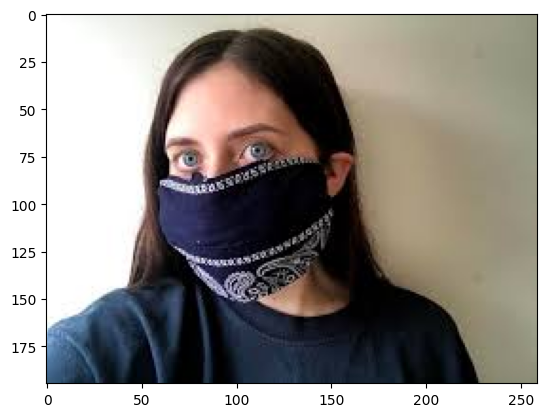

In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('/content/Total_Data/with_mask/with_mask_3689.jpg')
imgplot = plt.imshow(img)
plt.show()

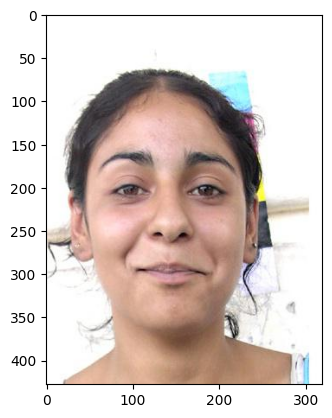

In [11]:
img = mpimg.imread('/content/Total_Data/without_mask/without_mask_1183.jpg')
imgplot = plt.imshow(img)
plt.show()

In [12]:
from PIL import Image

with_mask_path = '/content/Total_Data/with_mask/'
IMAGE_SIZE=128
data =[]

for img_file in with_mask_files:
  image = Image.open(with_mask_path + img_file)
  image = image.resize((IMAGE_SIZE,IMAGE_SIZE))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

without_mask_path = '/content/Total_Data/without_mask/'

for img_file in without_mask_files:
  image = Image.open(without_mask_path + img_file)
  image = image.resize((IMAGE_SIZE,IMAGE_SIZE))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
len(data)

9062

In [14]:
data[0].shape

(128, 128, 3)

In [15]:
X = np.array(data)
Y = np.array(labels)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [17]:
X_train = X_train/255.0
X_test = X_test/255.0

In [18]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    return self.features[index], self.labels[index]

In [19]:
train_dataset = CustomDataset(X_train, Y_train)
test_dataset = CustomDataset(X_test, Y_test)

In [20]:
import torch.nn.functional as F
class CNNtoMLP(nn.Module):

  def __init__(self, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super(CNNtoMLP, self).__init__()

    # CNN feature extractor (same as before)
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3)     # (128→126)
    self.pool = nn.MaxPool2d(2, 2)                   # (126→63)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3)    # (63→61) → (30 after pool)

    # Calculate flattened size after conv layers
    self.flattened_size = 64 * 30 * 30

    # MLP Layers from your architecture
    layers = []
    input_dim = self.flattened_size

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))
    self.mlp = nn.Sequential(*layers)


  def forward(self, x):
    # CNN Feature Extraction
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = x.reshape(x.size(0), -1)


    # Forward through MLP
    return self.mlp(x)

In [21]:
#Objective Function
def objective(trial):

  num_hidden_layers = trial.suggest_int("num_hidden_layers",1,5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10,50,step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5,1e-1,log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1,0.5,step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  output_dim = 2

  model = CNNtoMLP(output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)


   # optimizer selection
  criterion = nn.CrossEntropyLoss()

  if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      batch_features = batch_features.permute(0, 3, 1, 2)
      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      if len(batch_features)<2:
        continue

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      batch_features = batch_features.permute(0, 3, 1, 2)

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      if len(batch_features)<2:
        continue

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy


In [22]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 28.4 MB/s eta 0:00:00


In [23]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2025-08-02 06:37:33,183] A new study created in memory with name: no-name-8c76e491-f6a6-469e-8468-52b7e0d6ac43


In [24]:
study.optimize(objective, n_trials=15)

[I 2025-08-02 06:40:22,921] Trial 0 finished with value: 0.9553226696083839 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 56, 'epochs': 50, 'learning_rate': 0.0088748624470769, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 0.00016287633676460302}. Best is trial 0 with value: 0.9553226696083839.
[I 2025-08-02 06:41:53,579] Trial 1 finished with value: 0.9354660783232212 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 32, 'epochs': 30, 'learning_rate': 0.0012753138117941158, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer': 'RMSprop', 'weight_decay': 0.0001921147188914425}. Best is trial 0 with value: 0.9553226696083839.
[I 2025-08-02 06:42:28,973] Trial 2 finished with value: 0.9420849420849421 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 128, 'epochs': 10, 'learning_rate': 0.01120636061475793, 'dropout_rate': 0.5, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 9.190621345640474e-05}. Best is trial 0 wi

In [45]:
study.best_value

0.9602868174296746

In [46]:
best_params = study.best_params
best_params

{'num_hidden_layers': 4,
 'neurons_per_layer': 112,
 'epochs': 10,
 'learning_rate': 0.0011373891048316585,
 'dropout_rate': 0.1,
 'batch_size': 16,
 'optimizer': 'RMSprop',
 'weight_decay': 0.00027395581346796285}

Normal Training

In [47]:
batch_size = best_params['batch_size']
num_hidden_layers = best_params['num_hidden_layers']
neurons_per_layer = best_params['neurons_per_layer']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
weight_decay =  best_params['weight_decay']
epochs = best_params['epochs']

In [48]:
import torch.nn.functional as F
class CNNtoMLP(nn.Module):

  def __init__(self, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super(CNNtoMLP, self).__init__()

    # CNN feature extractor (same as before)
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3)     # (128→126)
    self.pool = nn.MaxPool2d(2, 2)                   # (126→63)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3)    # (63→61) → (30 after pool)

    # Calculate flattened size after conv layers
    self.flattened_size = 64 * 30 * 30

    # MLP Layers from your architecture
    layers = []
    input_dim = self.flattened_size

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))
    self.mlp = nn.Sequential(*layers)


  def forward(self, x):
    # CNN Feature Extraction
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = x.reshape(x.size(0), -1)


    # Forward through MLP
    return self.mlp(x)

In [56]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

output_dim = 2

model = CNNtoMLP(output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
model.to(device)

CNNtoMLP(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mlp): Sequential(
    (0): Linear(in_features=57600, out_features=112, bias=True)
    (1): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=112, out_features=112, bias=True)
    (5): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=112, out_features=112, bias=True)
    (9): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=112, out_features=112, bias=True)
    (13): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True, track_runn

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [59]:
for epoch in range(epochs):

  for batch_features, batch_labels in train_loader:

    batch_features = batch_features.permute(0, 3, 1, 2)
    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    if len(batch_features)<2:
      continue

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()


In [60]:
# evaluation
model.eval()
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    batch_features = batch_features.permute(0, 3, 1, 2)

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    if len(batch_features)<2:
      continue

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

  accuracy = correct/total
  print(accuracy)

0.9409817981246553


In [61]:
# evaluation
model.eval()
# evaluation on train data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    batch_features = batch_features.permute(0, 3, 1, 2)

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    if len(batch_features)<2:
      continue

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

  accuracy = correct/total
  print(accuracy)

0.9819260485651214


In [62]:
from sklearn.metrics import f1_score

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='weighted')  # or 'macro' / 'binary'
print("F1 Score on test data:", f1)


F1 Score on test data: 0.9407426431595827


In [63]:
from sklearn.metrics import f1_score

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='weighted')  # or 'macro' / 'binary'
print("F1 Score on test data:", f1)


F1 Score on test data: 0.9819161602006471


In [ ]:
torch.save(model, "face_mask_detection_pytorch.pth")